# Reccurent Neural Networks

This colab notebook is an introduction to Reccurent Neural Networks.

Suppose we have sequence data like, stock price, DNA sequence or comments o reddit. There is some kind of dependence of observations, i.e. stock price can depend on history of prices, each comment has some dependence to previous comment as it can be a reply. To encode this dependence into NN we can use Reccurent variants of it.

![alt text](https://miro.medium.com/max/5200/1*tBUpKzl1F8FU5K_eKBYDHA.png)

Suppose we want to predict stock prices of Google at time $t$, while we have the data on stock price of Google, Microsoft and Apple until time $t-1$ included. 

FFNN neuron has the following mathematical formulation.
$$h_t = \sigma(w_1x_{Gt}+w_2x_{At}+w_3x_{Mt}+b)$$
while reccurent neuron has the following mathematical formulation.
$$h_t = \sigma(w_1x_{Gt}+w_2x_{At}+w_3x_{Mt}+b+w_hh_{t-1})$$

Let's unfold it.

$$IN_t = w_1x_{Gt}+w_2x_{At}+w_3x_{Mt}+b$$<br>
$$h_t = \sigma(IN_t+w_hh_{t-1})$$<br>
$$h_t = \sigma(IN_t+w_h\sigma(IN_{t-1}+w_hh_{t-2})$$<br>
$$h_t = \sigma(IN_t+w_h\sigma(IN_{t-1}+w_h\sigma(IN_{t-2}+w_hh_{t-3})$$<br>
$$...$$<br>
$$h_t = \sigma(IN_t+w_h\sigma(IN_{t-1}+w_h\sigma(...\sigma(IN_{0}+w_h\sigma(IN_{0}+0w_h)$$<br>

![alt text](https://miro.medium.com/max/2800/1*DItCSHJ-NA2wy4lFfXv-_Q.png)

The backpropogation of RNN is similar to FFNN. However, there is weight sharing as in CNNs.

![alt text](https://dudeperf3ct.github.io/images/rnn/backprop_3.png)

Let's make an assumption that stock price is not affected by prices older than a month. Then we can divide our dataset into 30 day length chunks and consider them as observations. 

In [0]:
import pandas_datareader.data as web
from pandas_datareader import get_data_yahoo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# getting stock daily data
google = get_data_yahoo('GOOGL')
microsoft = get_data_yahoo('MSFT')
apple = get_data_yahoo('AAPL')

In [0]:
# calculating daily differences
google['diff'] = google['Adj Close'] - google['Adj Close'].shift(1)
microsoft['diff'] = microsoft['Adj Close'] - microsoft['Adj Close'].shift(1)
apple['diff'] = apple['Adj Close'] - apple['Adj Close'].shift(1)

In [0]:
# converting to 30 day samples
google_list = google['diff'].to_list()[1:]
microsoft_list = microsoft['diff'].to_list()[1:]
apple_list = apple['diff'].to_list()[1:]
X = []
for i in range(len(google_list)-30):
    gnp = np.array(google_list[i:i+30]).reshape(30,1)
    mnp = np.array(microsoft_list[i:i+30]).reshape(30,1)
    anp = np.array(apple_list[i:i+30]).reshape(30,1)
    x = np.concatenate([gnp,mnp,anp]).reshape(30,3)
    X.append(x)
Y = np.array(google_list[30:]).reshape(-1,1)
X = np.array(X)

In [0]:
from tensorflow.keras.layers import SimpleRNN,Dense,Dropout,BatchNormalization,Input
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
#X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3)
X_train = X[:-300]
X_test = X[-300:]
Y_train = Y[:-300]
Y_test = Y[-300:]

In [0]:
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1,90))
X_train_scaled = scaler.transform(X_train.reshape(-1,90)).reshape(-1,30,3)
X_test_scaled = scaler.transform(X_test.reshape(-1,90)).reshape(-1,30,3)

scaler_y = StandardScaler()
scaler_y.fit(Y_train)
Y_train_scaled = scaler_y.transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(SimpleRNN(128,return_sequences = True))
model.add(SimpleRNN(128,return_sequences = True))
model.add(SimpleRNN(128))
model.add(Dropout(0.8))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [0]:
model.fit(X_train_scaled,Y_train_scaled,
          batch_size = 64, epochs = 10, verbose = 1,
          validation_data= (X_test_scaled,Y_test_scaled))

Train on 2170 samples, validate on 300 samples
Epoch 1/10
2170/2170 [==============================] - 6s 3ms/sample - loss: 3.2870 - val_loss: 4.9489
Epoch 2/10
2170/2170 [==============================] - 2s 717us/sample - loss: 2.7569 - val_loss: 4.8351
Epoch 3/10
2170/2170 [==============================] - 2s 720us/sample - loss: 2.2982 - val_loss: 4.8529
Epoch 4/10
2170/2170 [==============================] - 2s 726us/sample - loss: 1.7890 - val_loss: 4.6289
Epoch 5/10
2170/2170 [==============================] - 2s 723us/sample - loss: 1.6915 - val_loss: 4.6785
Epoch 6/10
2170/2170 [==============================] - 2s 725us/sample - loss: 1.3746 - val_loss: 4.6659
Epoch 7/10
2170/2170 [==============================] - 2s 737us/sample - loss: 1.3617 - val_loss: 4.6581
Epoch 8/10
2170/2170 [==============================] - 2s 737us/sample - loss: 1.2514 - val_loss: 4.6004
Epoch 9/10
2170/2170 [==============================] - 2s 755us/sample - loss: 1.1513 - val_loss: 4.5779
E

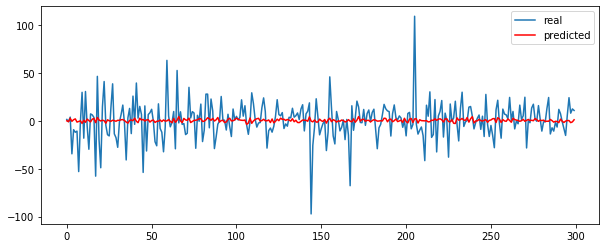

In [0]:
plt.figure(figsize = (10,4))
plt.plot(Y_test, label = 'real')
plt.plot(scaler_y.inverse_transform(model.predict(X_test_scaled)),
         'r',label = 'predicted')
plt.legend()
plt.show()

One of the problems with RNN is the vanishing and exploding gradient problem. When we apply sigmoid function over and over it either shrinks or explodes depending where we start. As in our example we apply more than 30 sigmoids to propogae the gradient it can be rather small or big.

![alt text](https://miro.medium.com/max/1400/1*gFC2bTg3uihp1klknWU0qg.gif)

To remedy this problem there are some variants of RNNs which try to add long term memory to neurons to preserve the gradients (like residual connections in ResNets). We will discuss those models in 2nd part.

on backprop http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/<br>
more on backprop with examples also on other RNNs https://datascience-enthusiast.com/DL/Building_a_Recurrent_Neural_Network-Step_by_Step_v1.html<br>
for other types https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [0]:
Y_train_bin = np.array([int(y>0) for y in Y_train])
Y_test_bin = np.array([int(y>0) for y in Y_test])

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(SimpleRNN(128,return_sequences = True))
model.add(SimpleRNN(128,return_sequences = True))
model.add(SimpleRNN(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

![alt text](http://i.imgur.com/J3DwxSF.png)

![alt text](https://i.stack.imgur.com/6VAOt.jpg)

In [0]:
model.fit(X_train_scaled,Y_train_bin,
          batch_size = 64, epochs = 10, verbose = 1,
          validation_data= (X_test_scaled,Y_test_bin))

Train on 2170 samples, validate on 300 samples
Epoch 1/10
2170/2170 [==============================] - 4s 2ms/sample - loss: 0.8159 - acc: 0.4972 - val_loss: 0.7371 - val_acc: 0.4967
Epoch 2/10
2170/2170 [==============================] - 2s 720us/sample - loss: 0.7585 - acc: 0.5290 - val_loss: 0.6994 - val_acc: 0.5200
Epoch 3/10
2170/2170 [==============================] - 2s 724us/sample - loss: 0.7356 - acc: 0.5276 - val_loss: 0.7069 - val_acc: 0.5233
Epoch 4/10
2170/2170 [==============================] - 2s 744us/sample - loss: 0.7453 - acc: 0.5355 - val_loss: 0.7029 - val_acc: 0.5067
Epoch 5/10
2170/2170 [==============================] - 2s 727us/sample - loss: 0.7288 - acc: 0.5327 - val_loss: 0.7094 - val_acc: 0.5000
Epoch 6/10
2170/2170 [==============================] - 2s 732us/sample - loss: 0.7043 - acc: 0.5493 - val_loss: 0.6851 - val_acc: 0.5367
Epoch 7/10
2170/2170 [==============================] - 2s 755us/sample - loss: 0.6932 - acc: 0.5751 - val_loss: 0.6996 - val_a

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['rise','fall']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


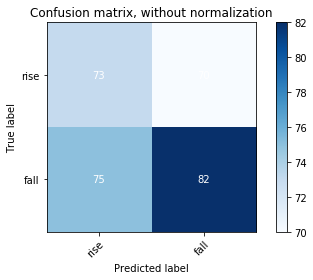

Normalized confusion matrix


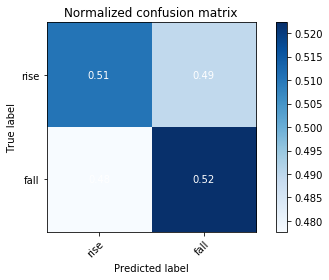

In [0]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test_bin, np.array([int(i>0.52) for i in model.predict(X_test_scaled)]),
                      classes=['rise','fall'],
                      title='Confusion matrix, without normalization')

plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(Y_test_bin, np.array([int(i>0.52) for i in model.predict(X_test_scaled)]),
                      classes=['rise','fall'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# LSTM & GRU

on LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/ also most images are from here

As was established above, RNNs have vanishing and exploding gradient problem.

![alt text](https://miro.medium.com/max/1400/1*gFC2bTg3uihp1klknWU0qg.gif)

To remedy this problem some new architectures of RNNs have been developed. Let's start with LSTM (Long-Short-Term-Memory)

![alt text](http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png)

So one of main differences of LSTM to RNN is that each neuron has 2 types of states, _cell state_ and _hidden state_. Hidden state has the same purpose as RNNs hidden state. Cell state is responsible for long-term memory.


In LSTM there are several things added for each neuron.

![alt text](https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg)

![alt text](http://1.bp.blogspot.com/-toFzRVSExjk/Wsm3nL4B6II/AAAAAAAAq28/Pgm3feMiV-wCpNPS5akJnOz7r77rOg5RwCK4BGAYYCw/s1600/picture-778945.jpg)

The first equation $f_t = \sigma(W_f[h_{t-1},x_t]+b_f)$ is the _forget gate_. Forget gate is responsible for memorizing or forgeting long term information. It receives as an input previous hidden state and multiples information aggregrated from with long-term memory. Thus, it forces the neuron to remember/forget long-term information which is related to previous state.

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

The second and third equations are the input gates. $i_t = \sigma(W_i[h_{t-1},x_t]+b_i)$, $\tilde{C}_t = tanh(W_C[h_{t-1},x_t]+b_C)$. The input gate is responsible for updating the long-term memory with new information.

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

After passing through those 2 gates long-term memory is updated with the fourth equation $C_t = f_t*C_{t-1} + i_t*\tilde{C}_t$.

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

The last 2 equations make the _output gate_. It's similar to simple RNNs case, however we also incroporate the information from the long-term memory.

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

In [0]:
from tensorflow.keras.layers import LSTM,GRU

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128))
model.add(Dropout(0.8))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [0]:
model.fit(X_train_scaled,Y_train_scaled,
          batch_size = 64, epochs = 10, verbose = 1,
          validation_data= (X_test_scaled,Y_test_scaled))

Train on 2170 samples, validate on 300 samples
Epoch 1/10
2170/2170 [==============================] - 16s 7ms/sample - loss: 1.0085 - val_loss: 4.6565
Epoch 2/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 1.0052 - val_loss: 4.6317
Epoch 3/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.9995 - val_loss: 4.6667
Epoch 4/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 1.0061 - val_loss: 4.6098
Epoch 5/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.9995 - val_loss: 4.6053
Epoch 6/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.9995 - val_loss: 4.5812
Epoch 7/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 1.0000 - val_loss: 4.6729
Epoch 8/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.9961 - val_loss: 4.6213
Epoch 9/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.9896 - val_loss: 4.7318
Epoch 10/10
2170

In [0]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc multiple                  12        
_________________________________________________________________
lstm_6 (LSTM)                multiple                  67584     
_________________________________________________________________
lstm_7 (LSTM)                multiple                  131584    
_________________________________________________________________
lstm_8 (LSTM)                multiple                  131584    
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  129       
Total params: 330,893
Trainable params: 330,887
Non-trainable params: 6
_______________________________________________

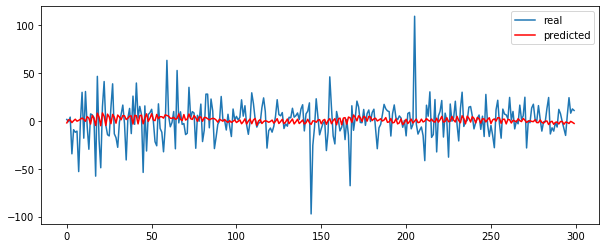

In [0]:
plt.figure(figsize = (10,4))
plt.plot(Y_test, label = 'real')
plt.plot(scaler_y.inverse_transform(model.predict(X_test_scaled)),
         'r',label = 'predicted')
plt.legend()
plt.show()

In [0]:
Y_train_bin = np.array([int(y>0) for y in Y_train])
Y_test_bin = np.array([int(y>0) for y in Y_test])

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128,return_sequences = True))
model.add(LSTM(128))
model.add(Dropout(0.8))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [0]:
model.fit(X_train_scaled,Y_train_bin,
          batch_size = 64, epochs = 10, verbose = 1,
          validation_data= (X_test_scaled,Y_test_bin))

Train on 2170 samples, validate on 300 samples
Epoch 1/10
2170/2170 [==============================] - 13s 6ms/sample - loss: 0.6932 - acc: 0.5180 - val_loss: 0.6969 - val_acc: 0.4800
Epoch 2/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.6966 - acc: 0.4972 - val_loss: 0.6916 - val_acc: 0.5067
Epoch 3/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.6924 - acc: 0.5166 - val_loss: 0.6909 - val_acc: 0.5400
Epoch 4/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.6917 - acc: 0.5101 - val_loss: 0.6959 - val_acc: 0.4967
Epoch 5/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.6921 - acc: 0.5272 - val_loss: 0.6913 - val_acc: 0.5133
Epoch 6/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.6933 - acc: 0.5069 - val_loss: 0.6959 - val_acc: 0.5000
Epoch 7/10
2170/2170 [==============================] - 9s 4ms/sample - loss: 0.6926 - acc: 0.5207 - val_loss: 0.6936 - val_acc: 0.5300


In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc multiple                  12        
_________________________________________________________________
lstm_9 (LSTM)                multiple                  67584     
_________________________________________________________________
lstm_10 (LSTM)               multiple                  131584    
_________________________________________________________________
lstm_11 (LSTM)               multiple                  131584    
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
dense_11 (Dense)             multiple                  129       
Total params: 330,893
Trainable params: 330,887
Non-trainable params: 6
_______________________________________________

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['rise','fall']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


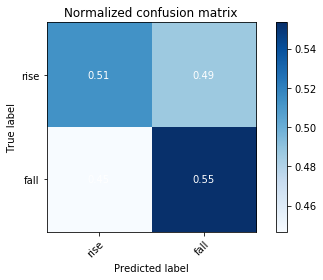

In [0]:
plot_confusion_matrix(Y_test_bin, [int(i>0.97) for i in model.predict(X_test_scaled)],
                      classes=['rise','fall'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Now let's examine GRU. A nice article on GRU: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

$z_t$ is responsible for weighing how much is previous information important than current information. $r_t$ is responsible on how much information should be forgeotten. $\tilde h_t$ is responsible for current information and $h_t$ is the final output which is a combination of current and previous information. 

GRU usually performs same as LSTM, but it has less parameters.

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(128,return_sequences = True))
model.add(GRU(128,return_sequences = True))
model.add(GRU(128))
model.add(Dropout(0.8))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [0]:
model.fit(X_train_scaled,Y_train_scaled,
          batch_size = 64, epochs = 10, verbose = 1,
          validation_data= (X_test_scaled,Y_test_scaled))

Train on 2170 samples, validate on 300 samples
Epoch 1/10
2170/2170 [==============================] - 15s 7ms/sample - loss: 1.0126 - val_loss: 4.6464
Epoch 2/10
2170/2170 [==============================] - 7s 3ms/sample - loss: 1.0003 - val_loss: 4.6504
Epoch 3/10
2170/2170 [==============================] - 7s 3ms/sample - loss: 1.0053 - val_loss: 4.6113
Epoch 4/10
2170/2170 [==============================] - 8s 3ms/sample - loss: 1.0077 - val_loss: 4.7688
Epoch 5/10
2170/2170 [==============================] - 7s 3ms/sample - loss: 0.9954 - val_loss: 4.6347
Epoch 6/10
2170/2170 [==============================] - 7s 3ms/sample - loss: 1.0029 - val_loss: 4.7060
Epoch 7/10
2170/2170 [==============================] - 7s 3ms/sample - loss: 0.9962 - val_loss: 4.6897
Epoch 8/10
2170/2170 [==============================] - 7s 3ms/sample - loss: 1.0020 - val_loss: 4.6894
Epoch 9/10
2170/2170 [==============================] - 7s 3ms/sample - loss: 0.9967 - val_loss: 4.7113
Epoch 10/10
2170

In [0]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc multiple                  12        
_________________________________________________________________
gru_9 (GRU)                  multiple                  50688     
_________________________________________________________________
gru_10 (GRU)                 multiple                  98688     
_________________________________________________________________
gru_11 (GRU)                 multiple                  98688     
_________________________________________________________________
dropout_12 (Dropout)         multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  129       
Total params: 248,205
Trainable params: 248,199
Non-trainable params: 6
_______________________________________________

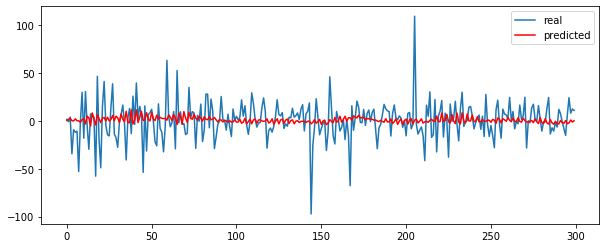

In [0]:
plt.figure(figsize = (10,4))
plt.plot(Y_test, label = 'real')
plt.plot(scaler_y.inverse_transform(model.predict(X_test_scaled)),
         'r',label = 'predicted')
plt.legend()
plt.show()

In [0]:
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(128,return_sequences = True))
model.add(GRU(128,return_sequences = True))
model.add(GRU(128))
model.add(Dropout(0.8))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [0]:
model.fit(X_train_scaled,Y_train_bin,
          batch_size = 64, epochs = 10, verbose = 1,
          validation_data= (X_test_scaled,Y_test_bin))

Train on 2170 samples, validate on 300 samples
Epoch 1/10
 128/2170 [>.............................] - ETA: 40s - loss: 0.6929 - acc: 0.4922 

KeyboardInterrupt: ignored

In [0]:
plot_confusion_matrix(Y_test_bin, [int(i>0.97) for i in model.predict(X_test_scaled)],
                      classes=['rise','fall'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

More exploration on LSTMs: http://blog.echen.me/2017/05/30/exploring-lstms/<br>
More on RNNs: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

more on backprop with examples also on other RNNs https://datascience-enthusiast.com/DL/Building_a_Recurrent_Neural_Network-Step_by_Step_v1.html<br>
more on LSTM and GRU https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [0]:
sentences = """I ate dinner.
We had a three-course meal.
Brad came to dinner with us.
He loves fish tacos.
In the end, we all felt like we ate too much.
We all agreed; it was a magnificent evening.
I hope that, when I've built up my savings, I'll be able to travel to Mexico.
Did you know that, along with gorgeous architecture, it's home to the largest tamale?
Wouldn't it be lovely to enjoy a week soaking up the culture?
Oh, how I'd love to go!
Of all the places to travel, Mexico is at the top of my list.
Would you like to travel with me?
Isn't language learning fun?
There is so much to understand.
I love learning!
Sentences come in many shapes and sizes.
Nothing beats a complete sentence.
Once you know all the elements, it's not difficult to pull together a sentence."""

In [0]:
sentences = sentences.split('\n')

In [0]:
sentences

['I ate dinner.',
 'We had a three-course meal.',
 'Brad came to dinner with us.',
 'He loves fish tacos.',
 'In the end, we all felt like we ate too much.',
 'We all agreed; it was a magnificent evening.',
 "I hope that, when I've built up my savings, I'll be able to travel to Mexico.",
 "Did you know that, along with gorgeous architecture, it's home to the largest tamale?",
 "Wouldn't it be lovely to enjoy a week soaking up the culture?",
 "Oh, how I'd love to go!",
 'Of all the places to travel, Mexico is at the top of my list.',
 'Would you like to travel with me?',
 "Isn't language learning fun?",
 'There is so much to understand.',
 'I love learning!',
 'Sentences come in many shapes and sizes.',
 'Nothing beats a complete sentence.',
 "Once you know all the elements, it's not difficult to pull together a sentence."]

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking,Embedding

In [0]:
# vocab is the size of vocabulary, tokenizer automatically drops
# infrequent words and replaces them with oov_token
vocab = 50
tokenizer = Tokenizer(num_words = vocab, oov_token='dummy')

In [0]:
tokenizer.fit_on_texts(sentences)

In [0]:
# 1 is always the dummy token
tokenized = tokenizer.texts_to_sequences(sentences)

In [0]:
tokenized

[[7, 11, 12],
 [5, 29, 4, 30, 31, 32],
 [33, 34, 2, 12, 8, 35],
 [36, 37, 38, 39],
 [13, 3, 40, 5, 6, 41, 14, 5, 11, 42, 15],
 [5, 6, 43, 16, 44, 4, 45, 46],
 [7, 47, 17, 48, 49, 1, 18, 19, 1, 1, 20, 1, 2, 9, 2, 21],
 [1, 10, 22, 17, 1, 8, 1, 1, 23, 1, 2, 3, 1, 1],
 [1, 16, 20, 1, 2, 1, 4, 1, 1, 18, 3, 1],
 [1, 1, 1, 24, 2, 1],
 [25, 6, 3, 1, 2, 9, 21, 26, 1, 3, 1, 25, 19, 1],
 [1, 10, 14, 2, 9, 8, 1],
 [1, 1, 27, 1],
 [1, 26, 1, 15, 2, 1],
 [7, 24, 27],
 [1, 1, 13, 1, 1, 1, 1],
 [1, 1, 4, 1, 28],
 [1, 10, 22, 6, 3, 1, 23, 1, 1, 2, 1, 1, 4, 28]]

In [0]:
# post padding
pad_sequences(tokenized,padding='post')

array([[ 7, 11, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5, 29,  4, 30, 31, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [33, 34,  2, 12,  8, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [36, 37, 38, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [13,  3, 40,  5,  6, 41, 14,  5, 11, 42, 15,  0,  0,  0,  0,  0],
       [ 5,  6, 43, 16, 44,  4, 45, 46,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7, 47, 17, 48, 49,  1, 18, 19,  1,  1, 20,  1,  2,  9,  2, 21],
       [ 1, 10, 22, 17,  1,  8,  1,  1, 23,  1,  2,  3,  1,  1,  0,  0],
       [ 1, 16, 20,  1,  2,  1,  4,  1,  1, 18,  3,  1,  0,  0,  0,  0],
       [ 1,  1,  1, 24,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [25,  6,  3,  1,  2,  9, 21, 26,  1,  3,  1, 25, 19,  1,  0,  0],
       [ 1, 10, 14,  2,  9,  8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1, 27,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 26,  1, 15,  2,  1,  0,  0,  0,  0,  0,

In [0]:
# pre padding
pad_sequences(tokenized,padding='pre')

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 11, 12],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 29,  4, 30, 31, 32],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33, 34,  2, 12,  8, 35],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 36, 37, 38, 39],
       [ 0,  0,  0,  0,  0, 13,  3, 40,  5,  6, 41, 14,  5, 11, 42, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  5,  6, 43, 16, 44,  4, 45, 46],
       [ 7, 47, 17, 48, 49,  1, 18, 19,  1,  1, 20,  1,  2,  9,  2, 21],
       [ 0,  0,  1, 10, 22, 17,  1,  8,  1,  1, 23,  1,  2,  3,  1,  1],
       [ 0,  0,  0,  0,  1, 16, 20,  1,  2,  1,  4,  1,  1, 18,  3,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1, 24,  2,  1],
       [ 0,  0, 25,  6,  3,  1,  2,  9, 21, 26,  1,  3,  1, 25, 19,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 10, 14,  2,  9,  8,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1, 27,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,

In [0]:
padded = pad_sequences(tokenized,padding='post')
max_len = padded.shape[1] # the maximum a sentence can be

In [0]:
model = Sequential()
# # Masking layer masks the values of 0s so they are not calculated
# model.add(Masking(mask_value=0., input_shape=(max_len,)))
# # embedding layer is very much like Dense but is exploiting the information
# # that it only recieves one hot vectors and becomes just a look up table
# model.add(Embedding(vocab, 8, input_length=None)) 
# we can do it in shorter version
model.add(Embedding(vocab, 8, input_length=None, mask_zero = True)) 
model.add(BatchNormalization())
model.add(GRU(128,return_sequences = True))
model.add(GRU(128,return_sequences = True))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [0]:
model.fit(padded,np.zeros(18),
          batch_size = 8, epochs = 10, verbose = 1)

Train on 18 samples
Epoch 1/10
18/18 [==============================] - 3s 151ms/sample - loss: 0.6293 - acc: 0.7778
Epoch 2/10
18/18 [==============================] - 0s 14ms/sample - loss: 0.3264 - acc: 1.0000
Epoch 3/10
18/18 [==============================] - 0s 14ms/sample - loss: 0.1130 - acc: 1.0000
Epoch 4/10
18/18 [==============================] - 0s 14ms/sample - loss: 0.0320 - acc: 1.0000
Epoch 5/10
18/18 [==============================] - 0s 14ms/sample - loss: 0.0084 - acc: 1.0000
Epoch 6/10
18/18 [==============================] - 0s 14ms/sample - loss: 0.0025 - acc: 1.0000
Epoch 7/10
18/18 [==============================] - 0s 14ms/sample - loss: 2.6533e-04 - acc: 1.0000
Epoch 8/10
18/18 [==============================] - 0s 14ms/sample - loss: 8.2238e-05 - acc: 1.0000
Epoch 9/10
18/18 [==============================] - 0s 14ms/sample - loss: 3.4355e-05 - acc: 1.0000
Epoch 10/10
18/18 [==============================] - 0s 15ms/sample - loss: 4.2550e-05 - acc: 1.0000


### Exercise
Try LSTM and GRU on imdb dataset

In [0]:
imdb_data = pd.read_csv('IMDB Dataset.csv')